# Data Preparation for LSTM Model

This notebook prepares the cleaned stock data for use with the LSTM model. LSTM requires sequential data formatted in a specific way:
- Input sequences of fixed length (lookback window)
- Data scaled to a consistent range (typically 0-1)
- Target values for each sequence

We'll process each of the 20 stock datasets and save them in the appropriate format.

In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## 1. Define Stock List and Data Paths

In [3]:
# List of stock symbols
stocks = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA", 
          "META", "NVDA", "SPY", "V", "DIS",
          "NFLX", "PYPL", "BABA", "IBM", "AMD",
          "BA", "INTC", "T", "GS", "NKE"]

# Paths for input and output data

# Path to the project root (go up 2 levels from this file)
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

# Correct paths
input_folder = os.path.join(project_root, "data", "cleaned")
output_folder = os.path.join(project_root, "data", "lstm", "initial")

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)


## 2. LSTM Data Preparation Function

For LSTM, we need to:
1. Select relevant features
2. Scale all features to a consistent range (0-1)
3. Include date information for reference, although it won't be used in the model directly
4. Add both next-day price and binary direction (up/down) targets

In [4]:
def prepare_lstm_data(df):
    """
    Prepare stock data for LSTM model.
    
    Parameters:
    - df: Cleaned dataframe with stock data
    
    Returns:
    - DataFrame formatted for LSTM
    """
    # Create a copy to avoid modifying the original
    lstm_df = df.copy()
    
    # Ensure date is in datetime format
    lstm_df['date'] = pd.to_datetime(lstm_df['date'])
    
    # Select features to use for LSTM
    feature_columns = [
        'open',
        'high',
        'low',
        'close',
        'volume',
        'return',
        'ma5',
        'ma20',
        'ma50',
        'volatility',
        'volume_ma20',
        'day_of_week',
        'month',
    ]
    
    # Filter features to those that exist in the dataset
    features = [col for col in feature_columns if col in lstm_df.columns]
    
    # Create a separate dataframe for scaling
    scaling_df = lstm_df[features].copy()
    
    # Initialize scaler
    scaler = MinMaxScaler()
    
    # Scale the features
    scaled_features = scaler.fit_transform(scaling_df)
    
    # Convert back to dataframe with proper column names
    scaled_df = pd.DataFrame(scaled_features, columns=[f"{col}_scaled" for col in features])
    
    # Add date column back
    scaled_df['date'] = lstm_df['date'].values
    
    # Add target variables
    if 'next_day_close' in lstm_df.columns:
        scaled_df['next_day_close'] = lstm_df['next_day_close']
        
        # Create a scaler just for the closing price
        close_scaler = MinMaxScaler()
        close_values = lstm_df[['close']].values
        close_scaler.fit(close_values)
        
        # Scale next day close
        next_day_values = lstm_df[['next_day_close']].values
        scaled_df['next_day_close_scaled'] = close_scaler.transform(next_day_values).flatten()
    
    # Add price direction (binary classification target)
    if 'price_up' in lstm_df.columns:
        scaled_df['price_up'] = lstm_df['price_up']
    
    # Add scaler parameters as metadata columns (for inverse scaling later)
    # We'll add min and max for each feature
    for i, feature in enumerate(features):
        scaled_df[f"{feature}_min"] = scaler.data_min_[i]
        scaled_df[f"{feature}_max"] = scaler.data_max_[i]
    
    # Add close_scaler parameters (most important for predictions)
    if 'next_day_close' in lstm_df.columns:
        scaled_df['close_min'] = close_scaler.data_min_[0]
        scaled_df['close_max'] = close_scaler.data_max_[0]
    
    return scaled_df

## 3. Process Each Stock and Save LSTM Format Data

In [6]:
results_summary = []

for stock in stocks:
    try:
        # Input file path
        input_file = f"{input_folder}/{stock}.csv"
        
        # Check if file exists
        if not os.path.exists(input_file):
            print(f"Warning: {input_file} does not exist. Skipping {stock}.")
            continue
        
        # Read cleaned data
        df = pd.read_csv(input_file)
        
        # Prepare data for LSTM
        lstm_df = prepare_lstm_data(df)
        
        # Output file path
        output_file = f"{output_folder}/{stock}_lstm.csv"
        
        # Save to CSV
        lstm_df.to_csv(output_file, index=False)
        
        # Collect summary statistics
        summary = {
            'stock': stock,
            'rows': len(lstm_df),
            'features': int((len(lstm_df.columns) - lstm_df.columns.str.contains('_min|_max|date|next_day|price_up').sum()) / 2),  # Divide by 2 because of _scaled columns
            'start_date': lstm_df['date'].min().strftime('%Y-%m-%d') if isinstance(lstm_df['date'].iloc[0], pd.Timestamp) else pd.to_datetime(lstm_df['date'].min()).strftime('%Y-%m-%d'),
            'end_date': lstm_df['date'].max().strftime('%Y-%m-%d') if isinstance(lstm_df['date'].iloc[0], pd.Timestamp) else pd.to_datetime(lstm_df['date'].max()).strftime('%Y-%m-%d'),
            'file_size_kb': round(os.path.getsize(output_file) / 1024, 2)
        }
        
        results_summary.append(summary)
        print(f"Processed {stock}: {len(lstm_df)} rows saved to {output_file}")
        
    except Exception as e:
        print(f"Error processing {stock}: {str(e)}")

# Create a summary DataFrame
summary_df = pd.DataFrame(results_summary)
print("\nData preparation for LSTM completed!")

/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])
/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])


Processed AAPL: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/AAPL_lstm.csv
Processed MSFT: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/MSFT_lstm.csv


/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])
/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])


Processed GOOG: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/GOOG_lstm.csv
Processed AMZN: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/AMZN_lstm.csv


/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])


Processed TSLA: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/TSLA_lstm.csv


/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])
/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])


Processed META: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/META_lstm.csv
Processed NVDA: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/NVDA_lstm.csv
Processed SPY: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/SPY_lstm.csv


/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])
/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])


Processed V: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/V_lstm.csv


/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])


Processed DIS: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/DIS_lstm.csv
Processed NFLX: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/NFLX_lstm.csv


/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])
/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])


Processed PYPL: 2477 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/PYPL_lstm.csv


/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])


Processed BABA: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/BABA_lstm.csv
Processed IBM: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/IBM_lstm.csv


/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])
/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])


Processed AMD: 2512 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/AMD_lstm.csv


/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])


Processed BA: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/BA_lstm.csv


/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])


Processed INTC: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/INTC_lstm.csv
Processed T: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/T_lstm.csv


/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])
/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])


Processed GS: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/GS_lstm.csv
Processed NKE: 2513 rows saved to /home/abderrahmane/Stock-Market-Predictor/data/lstm/NKE_lstm.csv

Data preparation for LSTM completed!


/tmp/ipykernel_21921/2823756281.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  lstm_df['date'] = pd.to_datetime(lstm_df['date'])


## 4. Display Summary of Prepared Datasets

In [7]:
# Display summary table
summary_df

,stock,rows,features,start_date,end_date,file_size_kb
0,AAPL,2513,6,2015-05-13,2025-05-08,1717.49
1,MSFT,2513,6,2015-05-13,2025-05-08,1705.56
2,GOOG,2513,6,2015-05-13,2025-05-08,1699.27
3,AMZN,2513,6,2015-05-13,2025-05-08,1714.99
4,TSLA,2513,6,2015-05-13,2025-05-08,1706.37
5,META,2513,6,2015-05-13,2025-05-08,1699.86
6,NVDA,2513,6,2015-05-13,2025-05-08,1753.35
7,SPY,2513,6,2015-05-13,2025-05-08,1701.79
8,V,2513,6,2015-05-13,2025-05-08,1669.54
9,DIS,2513,6,2015-05-13,2025-05-08,1701.93


## 5. Examine a Sample Dataset

Sample from AAPL_lstm.csv (First 5 rows):


,open_scaled,high_scaled,low_scaled,close_scaled,volume_scaled,return_scaled,ma5_scaled,ma20_scaled,ma50_scaled,volatility_scaled,price_up
0,0.032421,0.031590,0.032728,0.031860,0.184693,0.539055,0.033372,0.033351,0.030997,0.089094,1
1,0.033611,0.033243,0.033949,0.034629,0.251889,0.539055,0.033372,0.033351,0.030997,0.089094,0
2,0.035180,0.033750,0.034943,0.034460,0.207160,0.451348,0.033372,0.033351,0.030997,0.089094,1
3,0.034528,0.034904,0.035085,0.035797,0.288203,0.495413,0.033372,0.033351,0.030997,0.089094,0
4,0.036711,0.035055,0.036297,0.035684,0.248242,0.453031,0.033372,0.033351,0.030997,0.089094,0


/tmp/ipykernel_21921/4057071013.py:14: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  sample_df['date'] = pd.to_datetime(sample_df['date'])


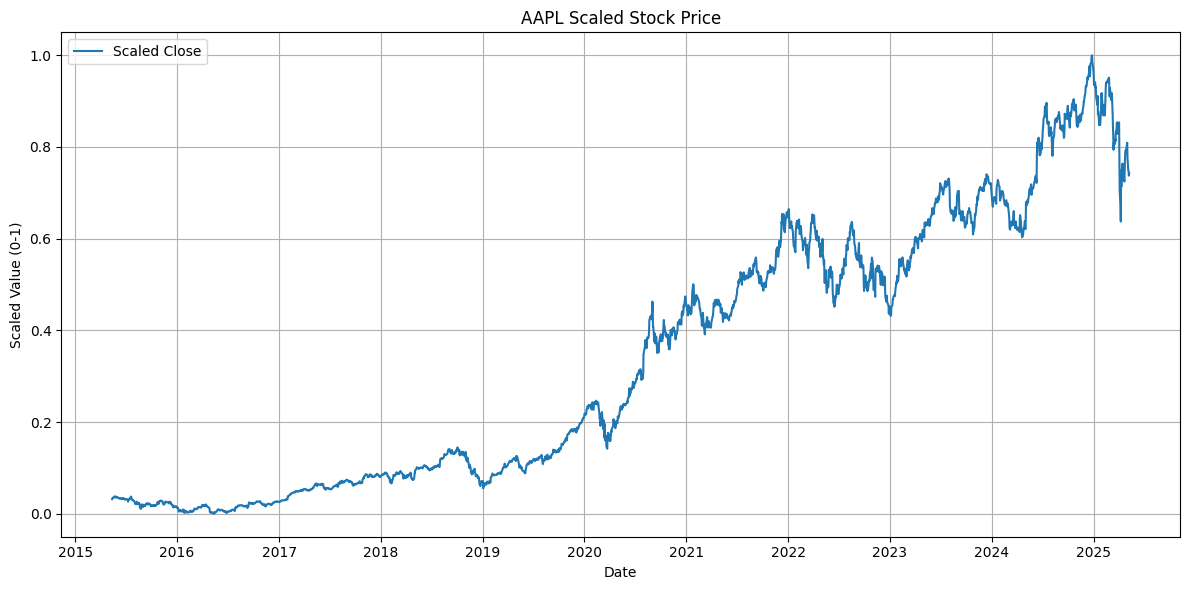

In [8]:
# Load sample dataset (AAPL)
sample_file = f"{output_folder}/AAPL_lstm.csv"
if os.path.exists(sample_file):
    sample_df = pd.read_csv(sample_file)
    print(f"Sample from AAPL_lstm.csv (First 5 rows):")
    
    # Show first few rows (limited columns for readability)
    display_cols = [col for col in sample_df.columns if 'min' not in col and 'max' not in col][:10]  # First 10 non-min/max columns
    display_cols.append('price_up')  # Add target
    display(sample_df[display_cols].head())
    
    # Plot the scaled closing prices
    plt.figure(figsize=(12, 6))
    sample_df['date'] = pd.to_datetime(sample_df['date'])
    
    if 'close_scaled' in sample_df.columns:
        plt.plot(sample_df['date'], sample_df['close_scaled'], label='Scaled Close')
        plt.title('AAPL Scaled Stock Price')
        plt.xlabel('Date')
        plt.ylabel('Scaled Value (0-1)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("Sample file not found. Please run the data preparation first.")

## 6. Helper Function to Create LSTM Sequences

This function shows how to create the input sequences for LSTM models from the prepared data. This will be used in the training notebook but is included here for reference.

In [7]:
def create_sequences(df, feature_cols, target_col, sequence_length=60):
    """
    Create sequences for LSTM training from prepared data.
    
    Parameters:
    - df: Prepared DataFrame with scaled features
    - feature_cols: List of feature column names to use
    - target_col: Name of the target column
    - sequence_length: Number of time steps in each sequence
    
    Returns:
    - X: Input sequences (3D array)
    - y: Target values
    """
    # Extract feature and target data
    data = df[feature_cols].values
    target = df[target_col].values
    
    X, y = [], []
    
    # Create sequences
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(target[i + sequence_length])
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Example usage (commented out)
"""
# Example for when you're building the LSTM model:
if os.path.exists(sample_file):
    # Get all scaled feature columns
    feature_cols = [col for col in sample_df.columns if col.endswith('_scaled') and col != 'next_day_close_scaled']
    
    # Create sequences for regression (predict next day price)
    X_price, y_price = create_sequences(sample_df, feature_cols, 'next_day_close_scaled', sequence_length=30)
    print(f"Regression sequences shape: {X_price.shape}, Target shape: {y_price.shape}")
    
    # Create sequences for classification (predict direction)
    X_dir, y_dir = create_sequences(sample_df, feature_cols, 'price_up', sequence_length=30)
    print(f"Classification sequences shape: {X_dir.shape}, Target shape: {y_dir.shape}")
"""

## 7. Data Ready for LSTM

Our data is now ready for training LSTM models. The prepared datasets include:

1. Scaled features (using MinMaxScaler)
2. Date information for reference
3. Next day price information (both raw and scaled)
4. Price direction binary target (0/1)
5. Scaling parameters (min/max) for each feature to use for inverse scaling predictions

The data is saved in the `/data/lstm/` directory with filenames like `STOCK_lstm.csv`.

In the LSTM model training notebook, we'll use the `create_sequences` function to generate the input sequences needed for training.